In [1]:
%matplotlib inline

In [2]:
import rasterio
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/g/data/v10/public/

In [3]:
import xarray as xr
import datacube

In [4]:
from collections import OrderedDict

#coefficients to convert s2 to ls7
s2_ls7_coefficients = {'blue':[-0.0022, 0.9551],
                       'green':[0.0031, 1.0582],
                       'red':[0.0064, 0.9871],
                       'nir':[0.012, 1.0187],
                       'swir1':[0.0079, 0.9528],
                       'swir2':[-0.0042, 0.9688]}

#coeffients to convert s2 to ls8
s2_ls8_coefficients = {'blue':[-0.0012, 0.963],
                       'green':[0.0013, 1.0473],
                       'red':[0.0027, 0.9895],
                       'nir':[0.0147, 1.0129],
                       'swir1':[0.0025, 0.9626],
                       'swir2':[-0.0011, 0.9392]}

def convert_sr(ds, coef):
    ds_corrected = ds.copy().astype(np.float32)
    # mask no data
    ds_corrected = ds_corrected.where(ds_corrected.to_array()>0, drop=False)
    for band in list(coef.keys()):
        ds_corrected[band] = (coef[band][0] + coef[band][1] * ds[band]/1e4)*1e4
    return ds_corrected.fillna(0)

def convert_ls8_to_ls7(ds):
    return convert_sr(ds, coef=ls8_ls7_coefficients)

def convert_s2_to_ls7(ds):
    return convert_sr(ds, coef=s2_ls7_coefficients)

def convert_s2_to_ls8(ds):
    return convert_sr(ds, coef=s2_ls8_coefficients)

s2_bands_translate=OrderedDict({'nbart_blue':'blue',
                                    'nbart_green':'green',
                                    'nbart_red':'red',
                                    'nbart_nir_1':'nir',
                                    'nbart_swir_2':'swir1',
                                    'nbart_swir_3':'swir2'})
s2_bands=list(s2_bands_translate.keys())

dc =datacube.Datacube()
query = {
        'time': ('2019-11-18','2019-11-20'), # for west australia
        'x': (148.4,148.6),
        'y': (-34.9, -34.7),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10)
        }
s2_data = dc.load(product = 's2b_ard_granule', measurements = s2_bands, group_by = 'solar_day', **query)
s2_data = convert_s2_to_ls7(s2_data.rename(s2_bands_translate))

In [5]:
# Run the prediction
fcModel = tf.keras.models.load_model('fcModel20191201.hd5')

W1219 14:50:05.292490 140432499611392 deprecation.py:506] From /g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1219 14:50:05.294159 140432499611392 deprecation.py:506] From /g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1219 14:50:05.296999 140432499611392 deprecation.py:506] From /g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/tensorflo

In [25]:
fcModel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               768       
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                

In [38]:
# The unmixing model
# applied on xarray dataset

def unmixfc_ds(input_ds, fcModel):
    fc_bands=['green','red','nir','swir1','swir2']
    input_data=input_ds[fc_bands].squeeze().to_array(dim='band').transpose('y','x','band').values/10000.0
    is_valid_array= ((input_data >0).all(axis=-1)) & ((input_data <1.).all(axis=-1))
    
    inshape = input_data.shape
    refData = input_data.reshape(inshape[0]*inshape[1],inshape[2])
    
    # Run the prediction
    fcLayers = fcModel.predict(refData)

    # Clip Output
    outputFC = np.clip(np.round(100 * fcLayers.T, 0),0,254)
    outputFC = outputFC.reshape(3, inshape[0],inshape[1])
    
    output_ds = xr.DataArray(outputFC, dims=('band','y','x'),
                        coords={'x':input_ds.x, 'y':input_ds.y, 'band':['PV', 'NPV', 'BS']})
    return output_ds.to_dataset(dim='band').where(is_valid_array, 255).astype(np.uint8)
    

In [39]:
%%time
output_ds  = unmixfc_ds(s2_data, fcModel)

CPU times: user 6min 53s, sys: 4min 35s, total: 11min 28s
Wall time: 2h 17min 53s


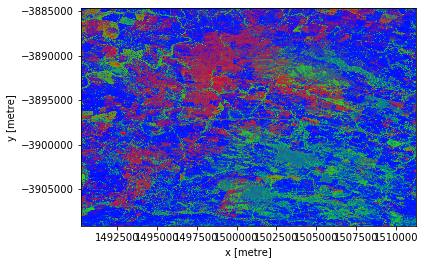

In [40]:
output_ds.to_array().plot.imshow(robust=True);

In [44]:
%%time
from fc.fractional_cover import compute_fractions

def compute_fc(input_ds):
    input_data = input_ds[['green','red','nir','swir1','swir2']].to_array().data
    is_valid_array= (input_data >0).all(axis=0)
    # Set nodata to 0                                                       
    input_data[:, ~is_valid_array] = 0
    # compute fractional_cover
    output_data = compute_fractions(input_data, None)
    output_data[:, ~is_valid_array] = -1
    outupt_ds = xr.DataArray(output_data, dims=('band','y','x'),
                        coords={'x':input_ds.x, 'y':input_ds.y, 'band':['PV', 'NPV', 'BS', 'UE']})
    return output_ds.to_dataset(name='band')

fc = compute_fc(s2_data)

AssertionError: 

In [42]:
fc.to_array().plot.imshow(robust=True);

NameError: name 'fc' is not defined

In [45]:
help(compute_fractions)

Help on function compute_fractions in module fc.fractional_cover:

compute_fractions(nbar, regression_coefficients)
    Compute the fractional cover of the given imagery tile
    
    :param numpy.array nbar: Input array of [green, red, nir, swir1, swir2] * (x, y)
    :return (numpy.array, numpy_array): Output array of [green, dead, bare] * (x, y), and the unmix error array

